In [1]:
%matplotlib inline

### Grab the smoothed functional data and movement regressors, events

In [2]:
import glob
import pandas as pd

func_imgs = glob.glob('*/MNINonLinear/Results/tfMRI_WM_RL/8mm_smooth_tfMRI_WM_RL.nii.gz')
regressors = glob.glob('*/MNINonLinear/Results/tfMRI_WM_RL/Movement_Regressors.txt')
events = pd.read_excel('onsets_dir.xlsx')
events = [events] * len(func_imgs)

### Acquisition parameters

In [3]:
tr = .72   # 720 milli seconds

#### Extract motion confounds to pandas data frame

In [4]:
import numpy as np

motion_names = ['mmx', 'mmy', 'mmz', 'degx', 'degy', 'degz',
                'dmmx', 'dmmx', 'dmmz', 'ddegx', 'ddegy', 'ddegz']
# (where the extra d in the front means derivative)

motions = []
for regressor in regressors:
    motions.append(pd.DataFrame(np.loadtxt(regressor),
                                columns=motion_names))

## GLM analysis - First Level Model

In [5]:
# define the model
from nistats.first_level_model import FirstLevelModel
fmri_glm = FirstLevelModel(tr, drift_model=None)

fmri_glm = fmri_glm.fit(run_imgs=func_imgs, events=events)

/home/kamalakar/Kamalakar/work/nistats/nistats/experimental_paradigm.py:57: UserWarning: 'trial_type' key not found in the given paradigm.
  warnings.warn("'trial_type' key not found in the given paradigm.")
/home/kamalakar/Kamalakar/work/nistats/nistats/experimental_paradigm.py:60: UserWarning: 'duration' key not found in the given paradigm.
  warnings.warn("'duration' key not found in the given paradigm.")


## Compute contrast maps - 0back and 2back

In [6]:
z_map_zero_back = fmri_glm.compute_contrast('0back', output_type='z_score')
z_map_two_back = fmri_glm.compute_contrast('2back', output_type='z_score')

/home/kamalakar/Kamalakar/work/nistats/nistats/first_level_model.py:539: UserWarning: One contrast given, assuming it for all 35 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


## Plot contrasts maps

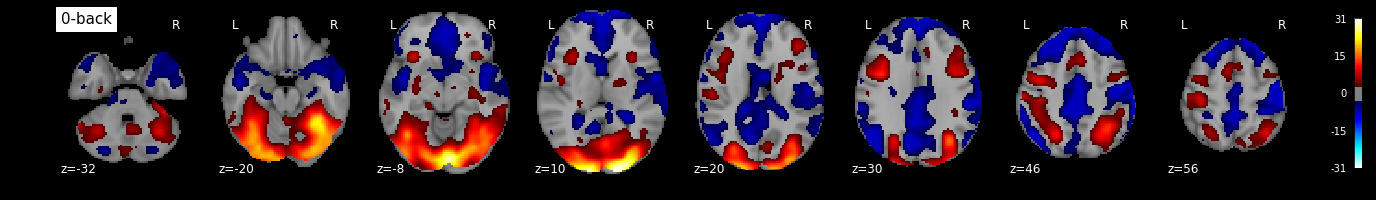

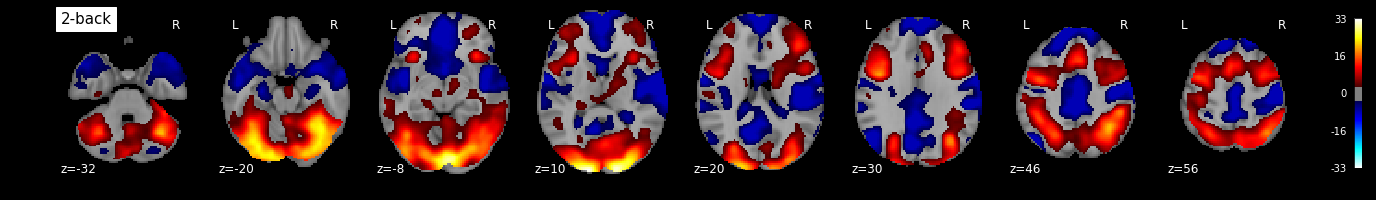

In [9]:
from nilearn.plotting import plot_stat_map

plot_stat_map(z_map_zero_back, threshold=3.0, display_mode='z',
              cut_coords=8, black_bg=True, title='0-back')
plot_stat_map(z_map_two_back, threshold=3.0, display_mode='z',
              cut_coords=8, black_bg=True, title='2-back')

## Plot design matrix

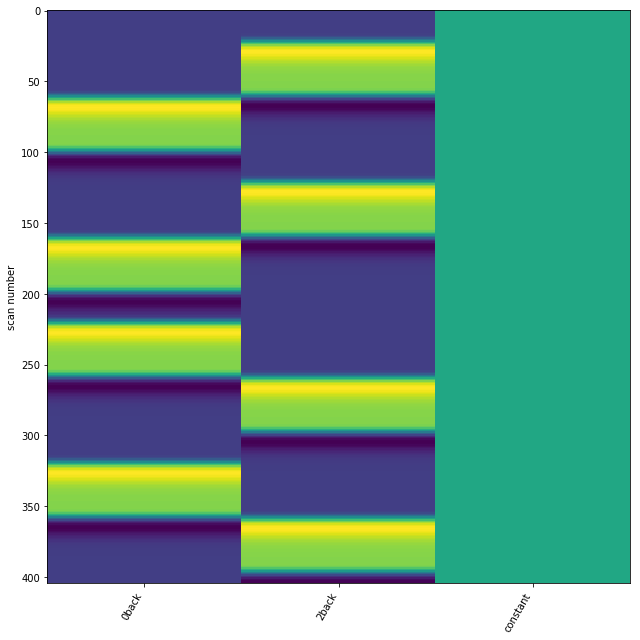

In [10]:
from nistats.reporting import plot_design_matrix
design_matrix = fmri_glm.design_matrices_[0]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,9))
plot_design_matrix(design_matrix, ax=ax)

## Build contrasts

In [11]:
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix.columns)])

### 2back - 0back

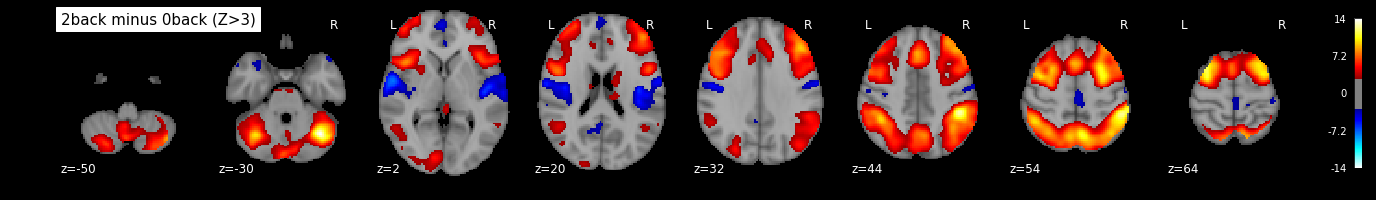

In [12]:
twobackminus0back = contrasts['2back'] - contrasts['0back']
z_map_2backminus0back = fmri_glm.compute_contrast(twobackminus0back, output_type='z_score')
plot_stat_map(z_map_2backminus0back, threshold=3,
              display_mode='z', cut_coords=8, black_bg=True,
              title='2back minus 0back (Z>3)')

### Extract peak coordinates from 0back and 2back z-maps

In [13]:
from nistats.reporting import get_clusters_table
# 0-back
coords_0back = get_clusters_table(z_map_zero_back, stat_threshold=10.0)
coords_0back = pd.DataFrame(coords_0back, columns=['X', 'Y', 'Z'])
coords_0back['task'] = pd.Series(['0-back'] * len(coords_0back),
                                 index=coords_0back.index)
coords_0back.to_csv('coordinates_0back.csv')

In [14]:
# 2-back
coords_2back = get_clusters_table(z_map_two_back, stat_threshold=10.0)
coords_2back = pd.DataFrame(coords_2back, columns=['X', 'Y', 'Z'])
coords_2back['task'] = pd.Series(['2-back'] * len(coords_2back),
                                 index=coords_2back.index)
coords_2back.to_csv('coordinates_2back.csv')

### Save peak coordinates

In [54]:
coords = pd.concat([coords_0back, coords_2back])
coords = coords.reset_index()
coords.to_csv('coordinates_0back_2back.csv')